# Basic Time Series2
---

[1. Time series variable](#1)  
[2. Data split](#2)  
[3. Scaler](#3)  
[4. Multicollinearity](#4)  
[5. LSIM model](#5)  


In [ ]:
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns

from tqdm import tqdm
from sklearn import preprocessing
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import LSTM



In [ ]:
### Datetime index
def non_feature_engineering(raw):    
    raw['datetime'] = pd.to_datetime(raw['datetime'])
    raw['DateTime'] = pd.to_datetime(raw['datetime'])
    raw.set_index('DateTime', inplace=True)
    raw = raw.asfreq('H', method='ffill')
    raw_nfe = raw.copy()
    return raw_nfe

### Feature engineering of all
def feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])

    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)  
    raw = raw.asfreq('H', method='ffill')

    result = sm.tsa.seasonal_decompose(raw['count'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'count_trend' not in raw.columns:
        if 'count_seasonal' not in raw.columns:
            raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)

    Y_count_Day = raw[['count']].rolling(24).mean()
    Y_count_Day.fillna(method='ffill', inplace=True)
    Y_count_Day.fillna(method='bfill', inplace=True)
    Y_count_Day.columns = ['count_Day']
    Y_count_Week = raw[['count']].rolling(24*7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns = ['count_Week']
    if 'count_Day' not in raw.columns:
        raw = pd.concat([raw, Y_count_Day], axis=1)
    if 'count_Week' not in raw.columns:
        raw = pd.concat([raw, Y_count_Week], axis=1)

    Y_diff = raw[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    if 'count_diff' not in raw.columns:
        raw = pd.concat([raw, Y_diff], axis=1)

    raw['temp_group'] = pd.cut(raw['temp'], 10)
    raw['Year'] = raw.datetime.dt.year
    raw['Quater'] = raw.datetime.dt.quarter
    raw['Quater_ver2'] = raw['Quater'] + (raw.Year - raw.Year.min()) * 4
    raw['Month'] = raw.datetime.dt.month
    raw['Day'] = raw.datetime.dt.day
    raw['Hour'] = raw.datetime.dt.hour
    raw['DayofWeek'] = raw.datetime.dt.dayofweek

    raw['count_lag1'] = raw['count'].shift(1)
    raw['count_lag2'] = raw['count'].shift(2)
    raw['count_lag1'].fillna(method='bfill', inplace=True)
    raw['count_lag2'].fillna(method='bfill', inplace=True)

    if 'Quater' in raw.columns:
        if 'Quater_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw.columns]:
            raw = pd.concat([raw, pd.get_dummies(raw['Quater'], 
                                                 prefix='Quater_Dummy', drop_first=True)], axis=1)
            del raw['Quater']
    raw_fe = raw.copy()
    return raw_fe

### Data split of time series
def datasplit_ts(raw, Y_colname, X_colname, criteria):
    raw_train = raw.loc[raw.index < criteria,:]
    raw_test = raw.loc[raw.index >= criteria,:]
    Y_train = raw_train[Y_colname]
    X_train = raw_train[X_colname]
    Y_test = raw_test[Y_colname]
    X_test = raw_test[X_colname]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test

## Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual

### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te
# Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)


### Error analysis
def stationarity_adf_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data)[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    else:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    return Stationarity_adf

def stationarity_kpss_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data)[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data)[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    else:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data[Target_name])[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data[Target_name])[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    return Stationarity_kpss

def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):
    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data['RowNum'] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sns.set(palette="muted", color_codes=True, font_scale=2)
        sns.lmplot(x='RowNum', y=Target_name, data=Y_Data, fit_reg='True', size=5.2, aspect=2, ci=99, sharey=True)
        del Y_Data['RowNum']

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(12,8))
        sns.distplot(Y_Data[Target_name], norm_hist='True', fit=stats.norm, ax=axes)

        # Lag Analysis
        length = int(len(Y_Data[Target_name])/10)
        figure, axes = plt.subplots(1, 4, figsize=(12,3))
        pd.plotting.lag_plot(Y_Data[Target_name], lag=1, ax=axes[0])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=5, ax=axes[1])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=10, ax=axes[2])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=50, ax=axes[3])

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(12,5))
        sm.tsa.graphics.plot_acf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[0])
        sm.tsa.graphics.plot_pacf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[1])

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity_adf = stationarity_adf_test(Y_Data, Target_name)
    Stationarity_kpss = stationarity_kpss_test(Y_Data, Target_name)

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # Checking for Autocorrelation
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
    Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Target_name], X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
    Score = pd.concat([Stationarity_adf, Stationarity_kpss, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
    index_new = ['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                 'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)', 'Maximum Information Criteria']
    Score.reindex(index_new)
    return Score

In [ ]:
### Functionalize
def feature_engineering_year_duplicated(raw, target):
    raw_fe = raw.copy()
    for col in target:
        raw_fe.loc['2012-01-01':'2012-02-28', col] = raw.loc['2011-01-01':'2011-02-28', col].values
        raw_fe.loc['2012-03-01':'2012-12-31', col] = raw.loc['2011-03-01':'2011-12-31', col].values
        step = (raw.loc['2011-03-01 00:00:00', col] - raw.loc['2011-02-28 23:00:00', col])/25
        step_value = np.arange(raw.loc['2011-02-28 23:00:00', col]+step, raw.loc['2011-03-01 00:00:00', col], step)
        step_value = step_value[:24]
        raw_fe.loc['2012-02-29', col] = step_value
    return raw_fe


### modify lagged values of X_test
def feature_engineering_lag_modified(Y_test, X_test, target):
    X_test_lm = X_test.copy()
    for col in target:
        X_test_lm[col] = Y_test.shift(1).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
        X_test_lm[col] = Y_test.shift(2).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
    return X_test_lm


### scaling of X_train and X_test by X_train_scaler
def feature_engineering_scaling(scaler, X_train, X_test):
    scaler = scaler
    scaler_fit = scaler.fit(X_train)
    X_train_scaling = pd.DataFrame(scaler_fit.transform(X_train), 
                               index=X_train.index, columns=X_train.columns)
    X_test_scaling = pd.DataFrame(scaler_fit.transform(X_test), 
                               index=X_test.index, columns=X_test.columns)
    return X_train_scaling, X_test_scaling

### extract non-multicollinearity variables by VIF 
def feature_engineering_XbyVIF(X_train, num_variables):
    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i) 
                         for i in range(X_train.shape[1])]
    vif['Feature'] = X_train.columns
    X_colname_vif = vif.sort_values(by='VIF_Factor', ascending=True)['Feature'][:num_variables].values
    return X_colname_vif

In [51]:
local_path = '../content/drive/My Drive/input/kaggle_data/bike_sharing_demand/Bike_Sharing_Demand_Full.csv'

In [52]:
df = pd.read_csv(local_path)

## Time series variable  
- DateTime Index
- Period 변환: asfreq() 'H'
- null값 처리
- 시계열 분해: seasonal_decompose()
- 이동평균: MA
- Y 변화량: diff()
- 지연값: shift()

In [ ]:
feature_engineering(df)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,DateTime,count_trend,count_seasonal,count_Day,count_Week,count_diff,temp_group,Year,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16,2011-01-01 00:00:00,41.06,-134.25,41.04,56.11,24.00,"(8.856, 12.874]",2011,1,1,1,0,5,16.00,16.00,0,0,0
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40,2011-01-01 01:00:00,41.06,-154.75,41.04,56.11,24.00,"(8.856, 12.874]",2011,1,1,1,1,5,16.00,16.00,0,0,0
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32,2011-01-01 02:00:00,41.06,-165.27,41.04,56.11,-8.00,"(8.856, 12.874]",2011,1,1,1,2,5,40.00,16.00,0,0,0
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13,2011-01-01 03:00:00,41.06,-176.48,41.04,56.11,-19.00,"(8.856, 12.874]",2011,1,1,1,3,5,32.00,40.00,0,0,0
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1,2011-01-01 04:00:00,41.06,-181.67,41.04,56.11,-12.00,"(8.856, 12.874]",2011,1,1,1,4,5,13.00,32.00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,2012-12-31 19:00:00,1,0,1,2,10.66,12.88,60,11.00,11,108,119,2012-12-31 19:00:00,113.71,122.70,110.17,73.30,-3.00,"(8.856, 12.874]",2012,8,12,31,19,0,122.00,164.00,0,0,1
2012-12-31 20:00:00,2012-12-31 20:00:00,1,0,1,2,10.66,12.88,60,11.00,8,81,89,2012-12-31 20:00:00,113.71,37.48,110.88,73.70,-30.00,"(8.856, 12.874]",2012,8,12,31,20,0,119.00,122.00,0,0,1
2012-12-31 21:00:00,2012-12-31 21:00:00,1,0,1,1,10.66,12.88,60,11.00,7,83,90,2012-12-31 21:00:00,113.71,-16.10,112.67,74.10,1.00,"(8.856, 12.874]",2012,8,12,31,21,0,89.00,119.00,0,0,1


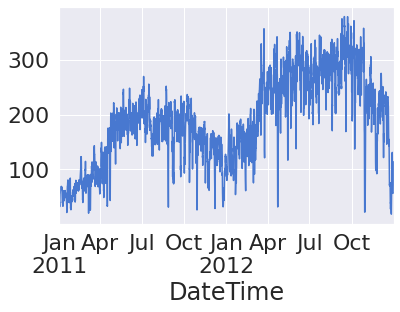

In [ ]:
# TS Data split
raw_fe['count_trend'].plot()

## Data split
- test 기간은 알수 없는 영역이 이상적
- 과거의 트렌드가 이후에도 반영될 것이라는 추청
- 트렌드 확인 후 반복되는 기간 대체


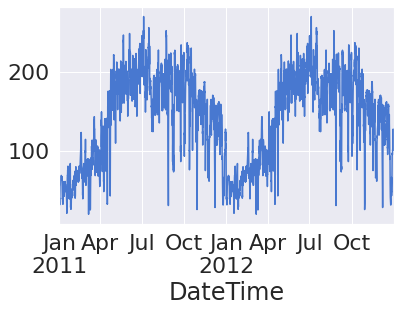

In [ ]:
### 'count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff' count variable
# ts split(train, test)
raw_fe.loc['2012-01-01':'2012-02-28', 'count_trend'] = raw_fe.loc['2011-01-01':'2011-02-28', 'count_trend'].values
raw_fe.loc['2012-03-01':'2012-12-31', 'count_trend'] = raw_fe.loc['2011-03-01':'2011-12-31', 'count_trend'].values
# 2012-02-29 value(step setting 24h)
step = (raw_fe.loc['2011-03-01 00:00:00', 'count_trend'] - raw_fe.loc['2011-02-28 23:00:00', 'count_trend'])/25
step_value = np.arange(raw_fe.loc['2011-02-28 23:00:00', 'count_trend']+step, 
                       raw_fe.loc['2011-03-01 00:00:00', 'count_trend'], step)
step_value = step_value[:24]
raw_fe.loc['2012-02-29', 'count_trend'] = step_value

raw_fe['count_trend'].plot()

In [55]:
# split samples 
X_train_fe, X_test_fe, Y_train_fe, Y_test_fe = datasplit_ts(raw_fe, Y_colname, X_colname, '2012-07-01')


Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


In [56]:
### TestSet lag variable bfill()
#  'count_lag1', 'count_lag2'
Y_test_fe.shift(1)

,count
DateTime,
2012-07-01 00:00:00,nan
2012-07-01 01:00:00,149.00
2012-07-01 02:00:00,93.00
2012-07-01 03:00:00,90.00
2012-07-01 04:00:00,33.00
...,...
2012-12-31 19:00:00,122.00
2012-12-31 20:00:00,119.00
2012-12-31 21:00:00,89.00


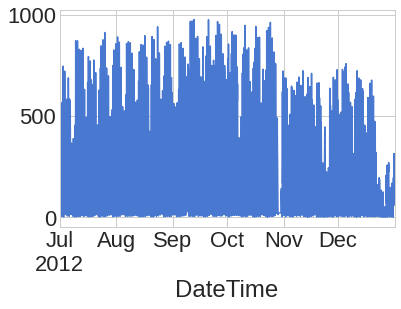

In [58]:
# TestSet lag (bfill)
X_test_fe['count_lag1'] = Y_test_fe.shift(1).values
X_test_fe['count_lag1'].fillna(method='bfill', inplace=True)
X_test_fe['count_lag2'] = Y_test_fe.shift(2).values
X_test_fe['count_lag2'].fillna(method='bfill', inplace=True)

X_test_fe['count_lag1'].plot()

## Scaler

`Standard Scaler`
1. 기본 스케일로 평균을 제외하고 표준편차를 나누어 변환  
2. Feature가 정규분포를 따른다는 가정 정규분포가 아닐 시 문제  
<center>$\dfrac{X_{it} - E(X_i)}{SD(X_i)}$</center>

`Min-Max Scaler` 
1. 최소\~최대 값이 0\~1 또는 -1\~1 사이의 값으로 변환 
2. Feature가 정규분포 X, 표준편차가 매우 작을 좋음  
<center>$\dfrac{X_{it} - min(X_i)}{max(X_i) - min(X_i)}$<center>

`Robust Scaler`
1. 최소-최대 스케일러와 유사하지만 최소/최대 대신에 IQR(Interquartile Range) 중 25%값/75%값을 사용하여 변환
2. Outlier에 영향을 최소화, 이상치 혹은 적은 row count 데이터 효과적  
<center>$\dfrac{X_{it} - Q_1(X_i)}{Q_3(X_i) - Q_1(X_i)}$</center>


- https://mkjjo.github.io/python/2019/01/10/scaler.html




In [60]:
# MinMax Scaler()
scaler = preprocessing.MinMaxScaler()
scaler_fit = scaler.fit(X_train_fe)
# train
X_train_feS = pd.DataFrame(scaler_fit.transform(X_train_fe), 
                           index=X_train_fe.index, columns=X_train_fe.columns)
# test
X_test_feS = pd.DataFrame(scaler_fit.transform(X_test_fe), 
                           index=X_test_fe.index, columns=X_test_fe.columns)

In [62]:
X_train_feS.describe().T

,count,mean,std,min,25%,50%,75%,max
season,"13,128.00",0.40,0.35,0.00,0.00,0.33,0.67,1.00
holiday,"13,128.00",0.03,0.17,0.00,0.00,0.00,0.00,1.00
workingday,"13,128.00",0.68,0.46,0.00,0.00,1.00,1.00,1.00
weather,"13,128.00",0.14,0.22,0.00,0.00,0.00,0.33,1.00
temp,"13,128.00",0.48,0.20,0.00,0.31,0.48,0.65,1.00
atemp,"13,128.00",0.46,0.17,0.00,0.32,0.47,0.61,1.00
humidity,"13,128.00",0.62,0.20,0.00,0.47,0.62,0.79,1.00
windspeed,"13,128.00",0.23,0.15,0.00,0.12,0.23,0.33,1.00
count_trend,"13,128.00",0.46,0.24,0.00,0.23,0.50,0.67,1.00
count_seasonal,"13,128.00",0.40,0.28,0.00,0.14,0.45,0.54,1.00


## Multicollinearity
- 특정 독립변수가 다른 독립변수의 조합으로 회귀분석으로 높은 설명력을 가지는 경우 
- 상관관계가 강한 경우
- 다중공선성이 높으면 Condition Number가 증가 --> Overfitting 가능성 증가
  
<center>
$VIF_i = Var(\hat{\beta}_i) = \dfrac{\sigma^2_{\epsilon}}{(n-1)Var(X_i)} \cdot \dfrac{1}{1-R_i^2} \\
$
</center>



In [65]:
# vif DataFrame
vif = pd.DataFrame()
vif['VIF_Factor'] = [variance_inflation_factor(X_train_feS.values, i) 
                     for i in range(X_train_feS.shape[1])]
vif['Feature'] = X_train_feS.columns
display(vif.sort_values(by='VIF_Factor', ascending=True)['Feature'][:10].values)
vif.sort_values(by='VIF_Factor', ascending=True)

array(['holiday', 'weather', 'Day', 'windspeed', 'Hour', 'DayofWeek',
       'workingday', 'count_seasonal', 'count_lag2', 'count_lag1'],
      dtype=object)

,VIF_Factor,Feature
1,1.42,holiday
3,2.05,weather
16,3.86,Day
7,3.95,windspeed
17,6.79,Hour
18,7.26,DayofWeek
2,7.37,workingday
9,9.29,count_seasonal
20,10.19,count_lag2
19,11.46,count_lag1


In [66]:
### Functionalize
### extract non-multicollinearity variables by VIF 
def feature_engineering_XbyVIF(X_train, num_variables):
    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i) 
                         for i in range(X_train.shape[1])]
    vif['Feature'] = X_train.columns
    X_colname_vif = vif.sort_values(by='VIF_Factor', ascending=True)['Feature'][:num_variables].values
    return X_colname_vif
# X_colname_vif = feature_engineering_XbyVIF(X_train_femm, 10)
# X_colname_vif

  0%|          | 0/24 [00:00<?, ?it/s]

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


  4%|▍         | 1/24 [00:00<00:15,  1.48it/s]

Number_of_Selected_X:  1


  8%|▊         | 2/24 [00:01<00:15,  1.46it/s]

Number_of_Selected_X:  2


 12%|█▎        | 3/24 [00:02<00:14,  1.47it/s]

Number_of_Selected_X:  3


 17%|█▋        | 4/24 [00:02<00:13,  1.47it/s]

Number_of_Selected_X:  4


 21%|██        | 5/24 [00:03<00:12,  1.46it/s]

Number_of_Selected_X:  5


 25%|██▌       | 6/24 [00:04<00:12,  1.47it/s]

Number_of_Selected_X:  6


 29%|██▉       | 7/24 [00:04<00:11,  1.48it/s]

Number_of_Selected_X:  7


 33%|███▎      | 8/24 [00:05<00:10,  1.48it/s]

Number_of_Selected_X:  8


 38%|███▊      | 9/24 [00:06<00:09,  1.52it/s]

Number_of_Selected_X:  9


 42%|████▏     | 10/24 [00:06<00:09,  1.51it/s]

Number_of_Selected_X:  10


 46%|████▌     | 11/24 [00:07<00:08,  1.53it/s]

Number_of_Selected_X:  11


 50%|█████     | 12/24 [00:08<00:07,  1.51it/s]

Number_of_Selected_X:  12


 54%|█████▍    | 13/24 [00:08<00:07,  1.51it/s]

Number_of_Selected_X:  13


 58%|█████▊    | 14/24 [00:09<00:06,  1.50it/s]

Number_of_Selected_X:  14


 62%|██████▎   | 15/24 [00:10<00:06,  1.49it/s]

Number_of_Selected_X:  15


 67%|██████▋   | 16/24 [00:10<00:05,  1.49it/s]

Number_of_Selected_X:  16


 71%|███████   | 17/24 [00:11<00:04,  1.53it/s]

Number_of_Selected_X:  17


 75%|███████▌  | 18/24 [00:12<00:04,  1.49it/s]

Number_of_Selected_X:  18


 79%|███████▉  | 19/24 [00:12<00:03,  1.49it/s]

Number_of_Selected_X:  19


 83%|████████▎ | 20/24 [00:13<00:02,  1.47it/s]

Number_of_Selected_X:  20


 88%|████████▊ | 21/24 [00:14<00:02,  1.45it/s]

Number_of_Selected_X:  21


 92%|█████████▏| 22/24 [00:14<00:01,  1.45it/s]

Number_of_Selected_X:  22


 96%|█████████▌| 23/24 [00:15<00:00,  1.45it/s]

Number_of_Selected_X:  23


100%|██████████| 24/24 [00:16<00:00,  1.48it/s]

Number_of_Selected_X:  24


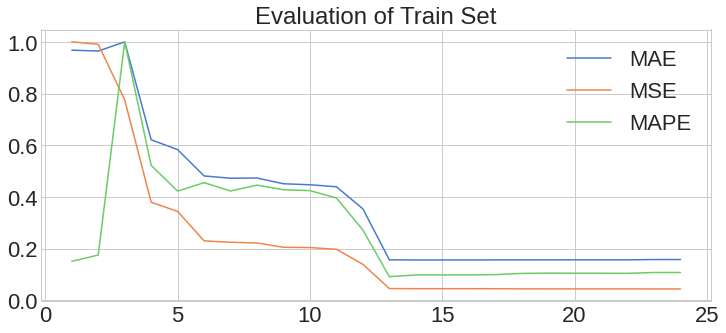

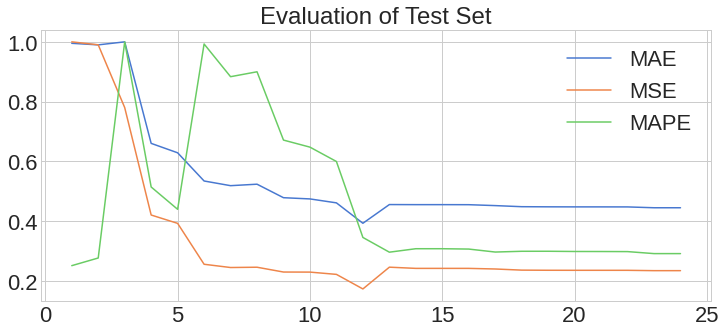

In [71]:
# Data Loading
local_path = '../content/drive/My Drive/input/kaggle_data/bike_sharing_demand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(local_path)

# Feature Engineering
raw_fe = feature_engineering(raw_all)
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)

# Data Split
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)
# Scaling
X_train_feRS, X_test_feRS = feature_engineering_scaling(preprocessing.Normalizer(), X_train_feR, X_test_feR)

eval_tr = pd.DataFrame()
eval_te = pd.DataFrame()
for i in tqdm(range(1,len(X_train_feRS.columns)+1)):
    X_colname_vif = feature_engineering_XbyVIF(X_train_feRS, i)
    print('Number_of_Selected_X: ', len(X_colname_vif))
    X_train_feRSM, X_test_feRSM = X_train_feRS[X_colname_vif].copy(), X_test_feRS[X_colname_vif].copy()
    
    # Applying Base Model
    fit_reg1_feRSM = sm.OLS(Y_train_feR, X_train_feRSM).fit()
    pred_tr_reg1_feRSM = fit_reg1_feRSM.predict(X_train_feRSM).values
    pred_te_reg1_feRSM = fit_reg1_feRSM.predict(X_test_feRSM).values

    # Evaluation
    Score_reg1_feRSM, Resid_tr_reg1_feRSM, Resid_te_reg1_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg1_feRSM,
                                                                       Y_test_feR, pred_te_reg1_feRSM, graph_on=False)
    eval_tr = pd.concat([eval_tr, Score_reg1_feRSM.loc[['Train']]], axis=0)
    eval_te = pd.concat([eval_te, Score_reg1_feRSM.loc[['Test']]], axis=0)
eval_tr.index = range(1,len(X_train_feRS.columns)+1)
eval_te.index = range(1,len(X_train_feRS.columns)+1)

plt.figure(figsize=(12,5))
plt.plot(eval_tr.index, eval_tr/eval_tr.max())
plt.legend(eval_tr.columns)
plt.title('Evaluation of Train Set')
plt.show()

plt.figure(figsize=(12,5))
plt.plot(eval_te.index, eval_te/eval_te.max())
plt.legend(eval_te.columns)
plt.title('Evaluation of Test Set')
plt.show()

## LSTM model
- Forget gate
- Input gate
- Output gate

![lstm](https://www.researchgate.net/profile/Savvas_Varsamopoulos/publication/329362532/figure/fig5/AS:699592479870977@1543807253596/Structure-of-the-LSTM-cell-and-equations-that-describe-the-gates-of-an-LSTM-cell.jpg)

In [ ]:
# Feature Engineering
raw_fe = feature_engineering(df)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)
###############


In [ ]:
# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')
# Reality
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)


Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


In [ ]:
# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 24
batch_size = 32
epoch = 10
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train_feR)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train_feR)
X_test_scaled = scaler_X_tr.transform(X_test_feR)
Y_test_scaled = scaler_Y_tr.transform(Y_test_feR)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(X_train_scaled) - sequence):
    X_train.append(np.array(X_train_scaled[index: index + sequence]))
    Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = [], []
for index in range(len(X_test_scaled) - sequence):
    X_test.append(np.array(X_test_scaled[index: index + sequence]))
    Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
X_test, Y_test = np.array(X_test), np.array(Y_test) 

## Retype and Reshape
X_train = X_train.reshape(X_train.shape[0], sequence, -1)
X_test = X_test.reshape(X_test.shape[0], sequence, -1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

X_train: (13104, 24, 24) Y_train: (13104, 1)
X_test: (4392, 24, 24) Y_test: (4392, 1)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 24, 128)           78336     
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 24, 256)           394240    
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 256)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 24, 128)           197120    
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 128)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)               

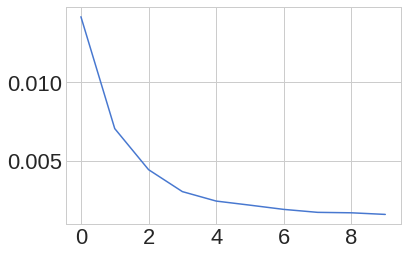

138/138 [==============================] - 7s 45ms/step - loss: 4.6633e-16


,MAE,MSE,MAPE
Train,20.97,"1,058.96",37.69
Test,50.28,"5,478.01",39.35


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-7.74,1.79,0.95,"2,263.24","3,763.51","4,103.99","7,010.07",0.91
p-value,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.03
Used Lag,26.00,31.00,nan,nan,nan,nan,nan,NaN
Used Observations,"4,365.00",nan,nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"45,919.07",nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,0.35,nan,nan,nan,nan,nan,NaN
Alternative,nan,nan,nan,nan,nan,nan,nan,two-sided


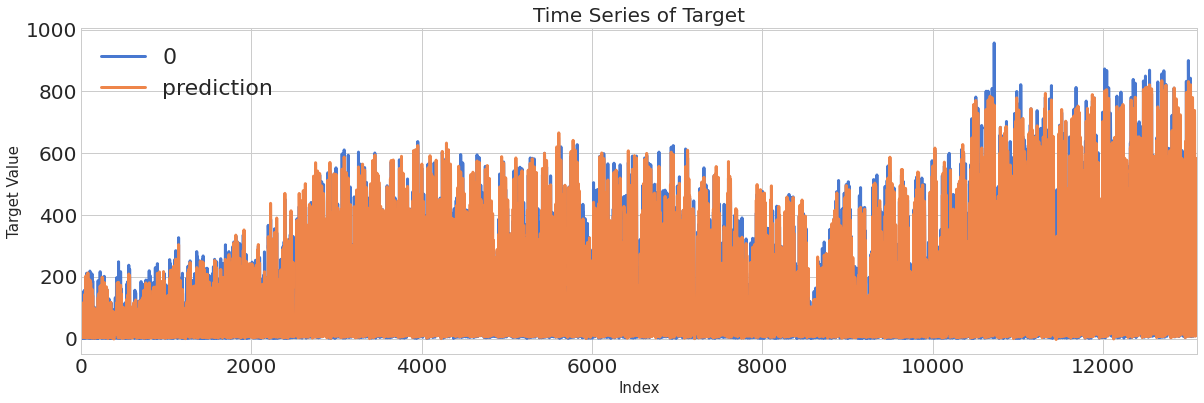

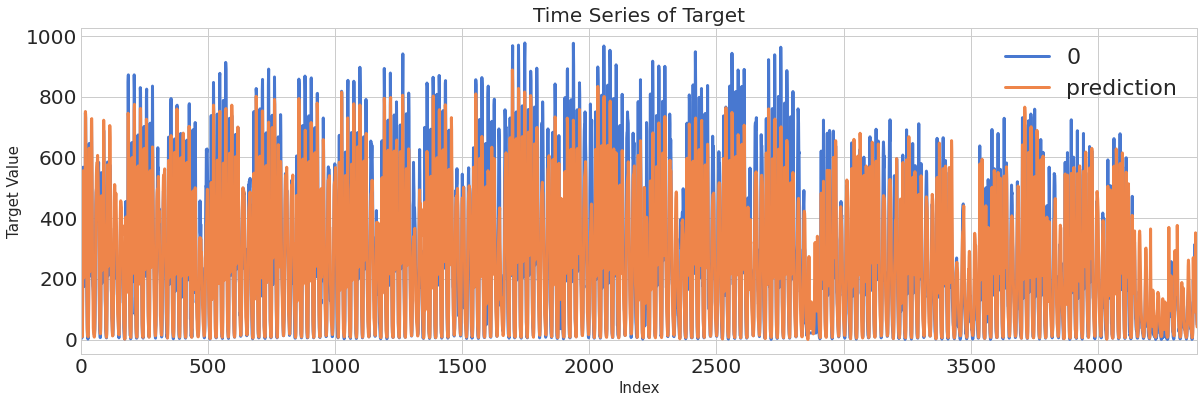

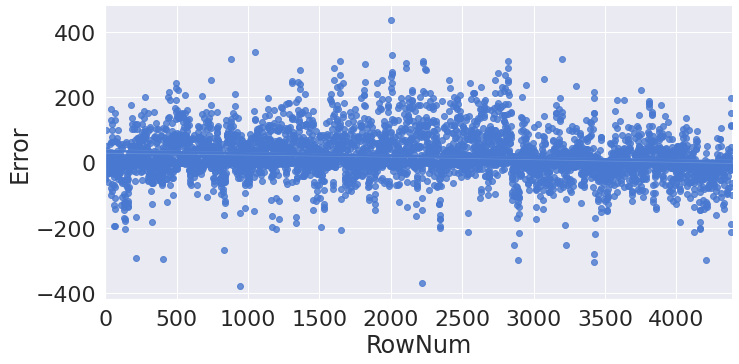

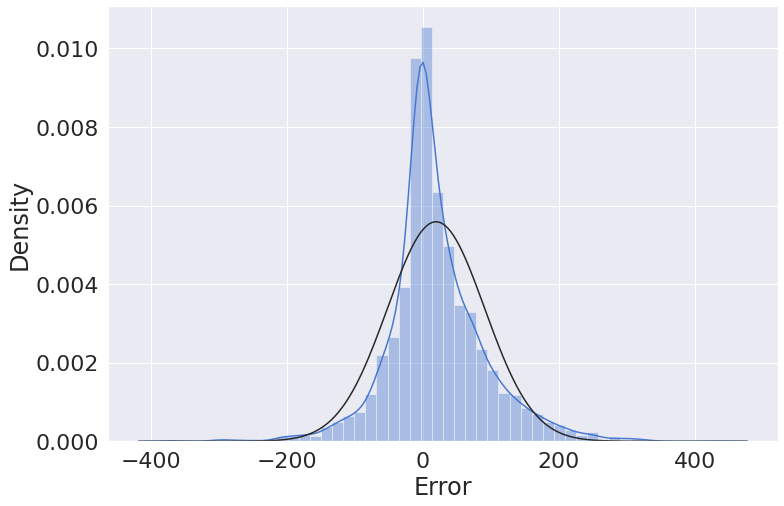

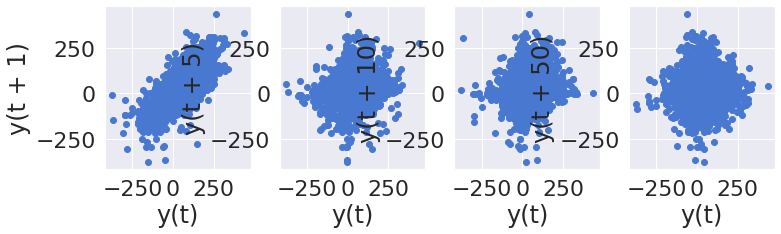

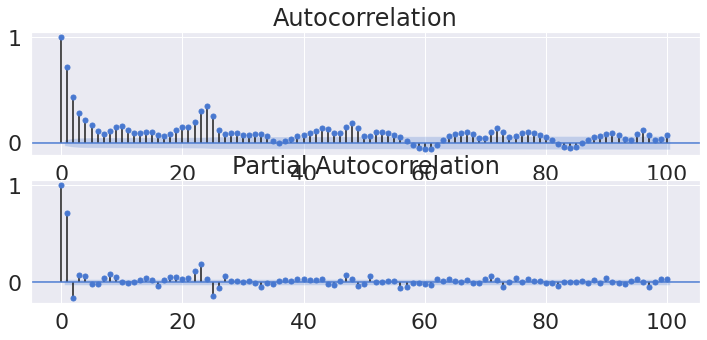

In [ ]:
# LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler_Y_tr != []:
    Y_train = scaler_Y_tr.inverse_transform(Y_train)
    Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
    Y_test = scaler_Y_tr.inverse_transform(Y_test)
    Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
Score_LSTM, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_LSTM)

# error analysis
error_analysis(Residual_te, ['Error'], X_test_feR.reset_index().iloc[:,1:].loc[Residual_te.index], graph_on=True)